# 2SFCA script test at Local Authority District (LAD) level

In [1]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl

# Data import and cleanning

## Get the centroid of LAD

In [2]:
LA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_raw/LAD_boundary.gpkg?raw=true')
LA = LA.to_crs('epsg:27700')

In [3]:
# clean data
drop_columns = ['OBJECTID','LAD20NM','Shape__Are','popden_sq_','over17_24','over16_64','up65']
LA.drop(columns=drop_columns, axis=1,inplace=True)
LA.head()

,LAD20CD,pop,geometry
0,E06000001,95934,"MULTIPOLYGON (((448906.042 536703.720, 448926...."
1,E06000002,144485,"MULTIPOLYGON (((451894.389 521145.406, 453997...."
2,E06000003,139072,"MULTIPOLYGON (((478227.056 518780.442, 477689...."
3,E06000004,197638,"MULTIPOLYGON (((452185.294 526288.478, 451741...."
4,E06000005,107558,"MULTIPOLYGON (((436388.002 522354.197, 437351...."


In [4]:
# copy poly to new GeoDataFrame
LA_points = LA.copy()
# change the geometry
LA_points.geometry = LA_points['geometry'].centroid
# same crs
LA_points.crs = LA.crs
LA_points.head()

,LAD20CD,pop,geometry
0,E06000001,95934,POINT (447853.611 530749.041)
1,E06000002,144485,POINT (450414.628 516717.389)
2,E06000003,139072,POINT (463487.686 517823.115)
3,E06000004,197638,POINT (443311.719 518610.690)
4,E06000005,107558,POINT (429079.949 517181.470)


<AxesSubplot:>

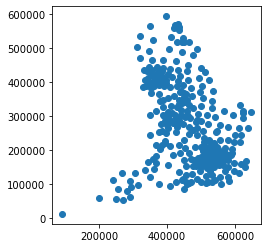

In [5]:
LA_points.plot()

## read site point data, clean and reformat

<AxesSubplot:>

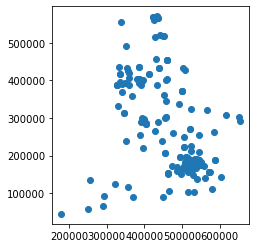

In [6]:
hospital = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_raw/hospital_hub.gpkg?raw=true')
hospital = hospital.to_crs('epsg:27700')
hospital.plot()

<AxesSubplot:>

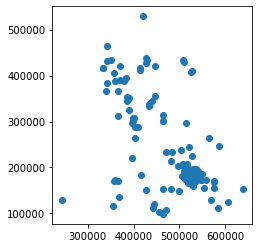

In [7]:
pharmacy = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_raw/pharmacy.gpkg?raw=true')
pharmacy = pharmacy.to_crs('epsg:27700')
pharmacy.plot()

<AxesSubplot:>

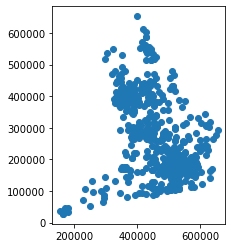

In [8]:
pcn = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_raw/primary_care_network.gpkg?raw=true')
pcn = pcn.to_crs('epsg:27700')
pcn.plot()

<AxesSubplot:>

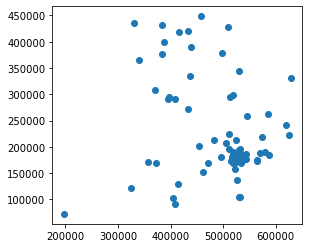

In [9]:
vc = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_raw/vaccination_centre.gpkg?raw=true')
vc = vc.to_crs('epsg:27700')
vc.plot()

In [10]:
# Drop useless columns
drop_columns = ['Region','ICS_STP','Trust_or_s','Address','Postcode','city','country','result_num','status','formatted_','place_id','location_t','latlong']
hospital.drop(columns=drop_columns, axis=1,inplace=True)

drop_columns = ['Region','CCG','Site_name','Address','Postcode','city','country','result_num','status','formatted_','place_id','location_t','latlong']
pcn.drop(columns=drop_columns, axis=1,inplace=True)

drop_columns = ['Name_of_si','Address','Postcode','city','country','result_num','status','formatted_','place_id','location_t','latlong']
pharmacy.drop(columns=drop_columns, axis=1,inplace=True)

drop_columns = ['Centre','Address','Postcode','city','country','result_num','status','formatted_','place_id','location_t','latlong']
vc.drop(columns=drop_columns, axis=1,inplace=True)

In [11]:
# format the dataframe
vc['hospital']=0
vc['pcn']=0
vc['pharmacy']=0
vc['vc']=1

hospital['hospital']=1
hospital['pcn']=0
hospital['pharmacy']=0
hospital['vc']=0

pharmacy['hospital']=0
pharmacy['pcn']=0
pharmacy['pharmacy']=1
pharmacy['vc']=0

pcn['hospital']=0
pcn['pcn']=1
pcn['pharmacy']=0
pcn['vc']=0

In [12]:
print("Hospital Hub number:",hospital.shape[0])
print("Primary Care Network number:",pcn.shape[0])
print("Pharmacy:",pharmacy.shape[0])
print("Vaccination Centre number:",vc.shape[0])

Hospital Hub number: 267
Primary Care Network number: 1018
Pharmacy: 200
Vaccination Centre number: 115


In [13]:
# concat four types of vaccination site data into one dataframe
site = pd.concat([hospital, pcn, pharmacy, vc], axis=0, ignore_index=True).reset_index()

## Data cleaning relults

### Demand point

In [14]:
LA_points.head()

,LAD20CD,pop,geometry
0,E06000001,95934,POINT (447853.611 530749.041)
1,E06000002,144485,POINT (450414.628 516717.389)
2,E06000003,139072,POINT (463487.686 517823.115)
3,E06000004,197638,POINT (443311.719 518610.690)
4,E06000005,107558,POINT (429079.949 517181.470)


In [15]:
print("Local Authority number:",LA_points.shape[0])

Local Authority number: 314


### Supply point

In [16]:
site.head()

,index,geometry,hospital,pcn,pharmacy,vc
0,0,POINT (504748.029 248914.642),1,0,0,0
1,1,POINT (505059.230 222903.988),1,0,0,0
2,2,POINT (532504.110 176066.629),1,0,0,0
3,3,POINT (532504.110 176066.629),1,0,0,0
4,4,POINT (504396.617 222557.941),1,0,0,0


In [17]:
print("Vaccination site number:",site.shape[0])

Vaccination site number: 1600


# Calculate the Euclidean distance from demand to supply locations 

In [18]:
# Load each of the example datasets which correspond to the demand (population) and supply ('hospital','pcn','pharmacy','vc') respectively.
distance = access(demand_df = LA_points,
           demand_index='LAD20CD',
           demand_value='pop',
           supply_df= site,
           supply_index= 'index',
           supply_value=['hospital','pcn','pharmacy','vc'])

In [19]:
# reproject
distance.demand_df = distance.demand_df.to_crs('epsg:27700')
distance.supply_df = distance.supply_df.to_crs('epsg:27700')

In [20]:
# Take 150000 meters as the calculation threshold
distance.create_euclidean_distance(threshold = 150000)

In [21]:
distance.cost_df

,euclidean,origin,dest
0,44557.491905,E06000001,119
1,44557.491905,E06000001,120
2,112076.172944,E06000001,121
3,11221.816362,E06000001,122
4,41801.311362,E06000001,123
...,...,...,...
236270,124543.099343,E09000033,1592
236271,1192.189329,E09000033,1594
236272,9467.950240,E09000033,1596
236273,938.866511,E09000033,1597


# Create a dataframe for the accessibility calculation using the Euclidean distance from the point of demand to the point of supply as cost

In [22]:
fca = access(demand_df = LA_points,
           demand_index='LAD20CD',
           demand_value='pop',
           supply_df= site,
           supply_index= 'index',
           supply_value=['hospital','pcn','pharmacy','vc'],
           cost_df              = distance.cost_df,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'euclidean',
           neighbor_cost_df     = distance.cost_df,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'euclidean')

In [23]:
# Using 2SFCA method, 1e5 and 1e4 meters are used as service boundary radius to calculate the accessibility
fca.two_stage_fca(name = "2sfca5",max_cost = 1e5)
fca.two_stage_fca(name = "2sfca4",max_cost = 1e4)

,2sfca4_hospital,2sfca4_pcn,2sfca4_pharmacy,2sfca4_vc
LAD20CD,,,,
E06000001,0.000000,0.000010,0.000000,0.000000
E06000002,0.000009,0.000015,0.000000,0.000000
E06000003,0.000000,0.000007,0.000000,0.000000
E06000004,0.000009,0.000015,0.000000,0.000000
E06000005,0.000009,0.000009,0.000000,0.000000
...,...,...,...,...
E09000029,0.000008,0.000034,0.000006,0.000005
E09000030,0.000028,0.000095,0.000020,0.000014
E09000031,0.000009,0.000055,0.000010,0.000006


## See the result

In [24]:
fca.access_df

,pop,2sfca5_hospital,2sfca5_pcn,2sfca5_pharmacy,2sfca5_vc,2sfca4_hospital,2sfca4_pcn,2sfca4_pharmacy,2sfca4_vc
LAD20CD,,,,,,,,,
E06000001,95934,0.000004,0.000008,3.266134e-07,9.193422e-08,0.000000,0.000010,0.000000,0.000000
E06000002,144485,0.000004,0.000009,4.645032e-07,1.577418e-07,0.000009,0.000015,0.000000,0.000000
E06000003,139072,0.000004,0.000009,6.133463e-07,9.193422e-08,0.000000,0.000007,0.000000,0.000000
E06000004,197638,0.000004,0.000009,4.645032e-07,1.577418e-07,0.000009,0.000015,0.000000,0.000000
E06000005,107558,0.000004,0.000009,4.645032e-07,2.355719e-07,0.000009,0.000009,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
E09000029,209374,0.000008,0.000033,7.047712e-06,3.983324e-06,0.000008,0.000034,0.000006,0.000005
E09000030,320658,0.000008,0.000033,6.677944e-06,4.180902e-06,0.000028,0.000095,0.000020,0.000014
E09000031,280345,0.000008,0.000033,6.609037e-06,4.303478e-06,0.000009,0.000055,0.000010,0.000006


# Combine the results into a standardized accessibility value based on the weight of the vaccination services of different type

Manually sum weighted accessibility

In [25]:
#fca_combo = pd.DataFrame()
#fca_combo['2sfca4_combo'] = (fca.access_df['2sfca4_hospital']+fca.access_df['2sfca4_pcn']+fca.access_df['2sfca4_pharmacy']+fca.access_df['2sfca4_vc'])*0.25
#fca_combo['2sfca5_combo'] = (fca.access_df['2sfca5_hospital']+fca.access_df['2sfca5_pcn']+fca.access_df['2sfca5_pharmacy']+fca.access_df['2sfca5_vc'])*0.25
#fca_combo = fca_combo.reset_index()
#fca_combo.columns=['LAD20CD','2sfca4_combo','2sfca5_combo']
#fca_combo

Use score function to sum weighted accessibility

In [26]:
fca.score(name = "2sfca5_combo", col_dict = {"2sfca5_hospital" : 0.25, "2sfca5_pcn" : 0.25,"2sfca5_pharmacy": 0.25, "2sfca5_vc": 0.25})
fca.score(name = "2sfca4_combo", col_dict = {"2sfca4_hospital" : 0.25, "2sfca4_pcn" : 0.25,"2sfca4_pharmacy": 0.25, "2sfca4_vc": 0.25})

LAD20CD
E06000001    0.163540
E06000002    0.718683
E06000003    0.112813
E06000004    0.718683
E06000005    0.664757
               ...   
E09000029    2.056587
E09000030    6.505700
E09000031    2.828594
E09000032    5.960341
E09000033    7.042174
Name: 2sfca4_combo, Length: 314, dtype: float64

In [27]:
fca_combo = fca.access_df[['2sfca5_combo','2sfca4_combo']]
fca_combo

,2sfca5_combo,2sfca4_combo
LAD20CD,,
E06000001,0.352010,0.163540
E06000002,0.381793,0.718683
E06000003,0.390746,0.112813
E06000004,0.388631,0.718683
E06000005,0.426373,0.664757
...,...,...
E09000029,1.877288,2.056587
E09000030,1.879577,6.505700
E09000031,1.895192,2.828594


# Show the accessibility result on map

In [28]:
LA_fca = pd.merge(left=LA, right=fca_combo, how='left', left_on='LAD20CD', right_on='LAD20CD')
LA_fca=LA_fca.fillna(0)
LA_fca

,LAD20CD,pop,geometry,2sfca5_combo,2sfca4_combo
0,E06000001,95934,"MULTIPOLYGON (((448906.042 536703.720, 448926....",0.352010,0.163540
1,E06000002,144485,"MULTIPOLYGON (((451894.389 521145.406, 453997....",0.381793,0.718683
2,E06000003,139072,"MULTIPOLYGON (((478227.056 518780.442, 477689....",0.390746,0.112813
3,E06000004,197638,"MULTIPOLYGON (((452185.294 526288.478, 451741....",0.388631,0.718683
4,E06000005,107558,"MULTIPOLYGON (((436388.002 522354.197, 437351....",0.426373,0.664757
...,...,...,...,...,...
309,E09000029,209374,"MULTIPOLYGON (((529904.494 167407.581, 531249....",1.877288,2.056587
310,E09000030,320658,"MULTIPOLYGON (((539050.635 180282.814, 539010....",1.879577,6.505700
311,E09000031,280345,"MULTIPOLYGON (((540036.303 194159.702, 539157....",1.895192,2.828594
312,E09000032,337492,"MULTIPOLYGON (((529404.296 170556.840, 526498....",1.880623,5.960341


check the distribution

<AxesSubplot:>

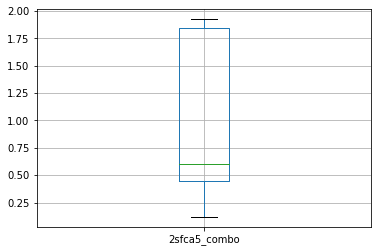

In [29]:
LA_fca.boxplot(column='2sfca5_combo')

<AxesSubplot:>

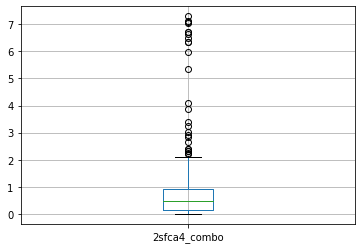

In [30]:
LA_fca.boxplot(column='2sfca4_combo')

In [31]:
def plot_access(access_metric):
    base = LA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = LA_fca[access_metric].quantile(0.05), vmax = LA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})
    site.plot(ax=base, markersize=1, color='red')

### When the service radius is 10000 meters:

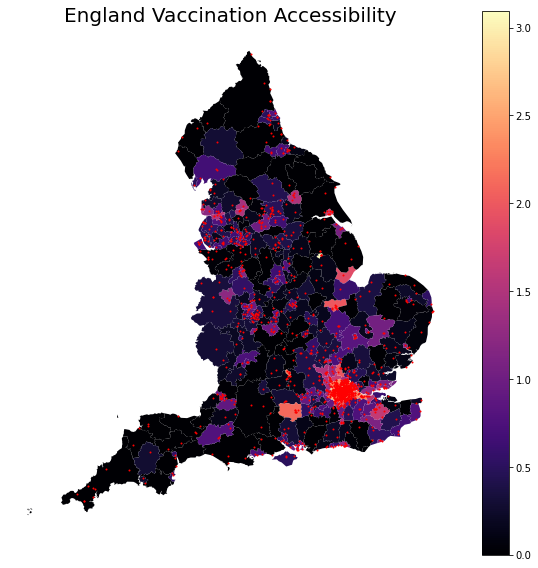

In [32]:
plot_access('2sfca4_combo')

### When the service radius is 100000 meters:

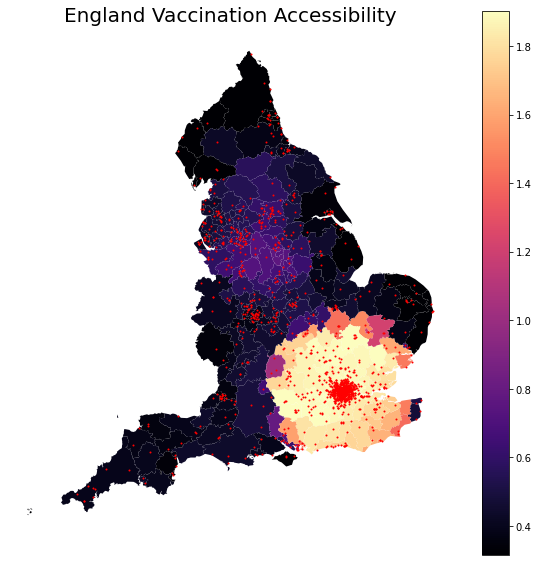

In [33]:
plot_access('2sfca5_combo')

## Another way to visulize

In [34]:
def combo(column):
    f,ax = plt.subplots(figsize=(10,10))
    LA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessbility")

    q = mc.NaturalBreaks(LA_fca[column], k=7)
    legendgram(f, ax, 
                LA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False
        )

### When the service radius is 10000 meters:

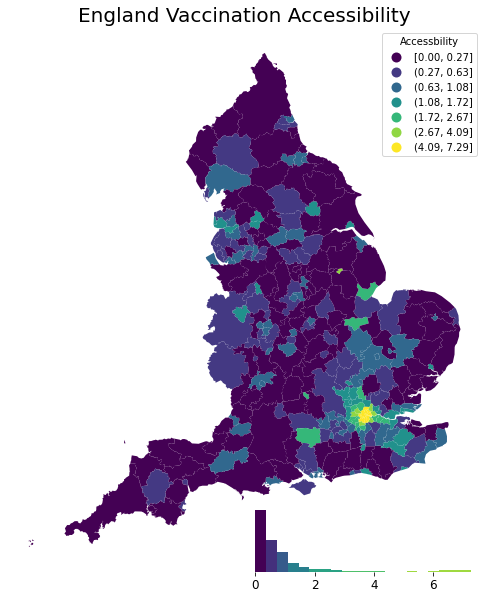

In [35]:
combo('2sfca4_combo')

### When the service radius is 100000 meters:

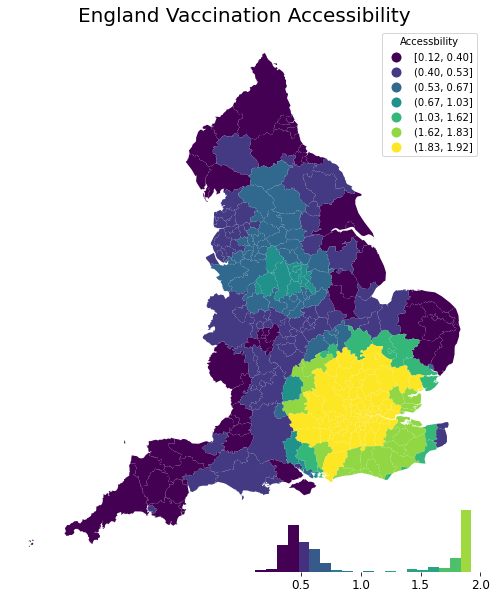

In [36]:
combo('2sfca5_combo')